# Self Supervised Learning

Finetuning BERT variant (Distilbert) for Semantic Similarity using contrastive loss.

The dataset used is Quora Question Pairs. Which contains pairs of questions and a label indicating if the questions are similar or not.

contrastive loss is suited for this task as it tries to bring similar questions closer in the embedding space and push dissimilar questions apart.

In [1]:
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import torch
import torch.nn as nn

#### Quora Question Pairs

The dataset contains 404,290 pairs of questions. Each row contains IDs for each question in the pair, the full text for each question, and a binary value that indicates if the questions are duplicates.

In [5]:
train_dataset = load_dataset("quora", split="train[:4000]")
val_dataset = load_dataset("quora", split="train[4000:5000]")

d:\Conda\envs\torchenv\lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for quora contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/quora
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [6]:
for i in range(10):
    print(train_dataset[i]) # print the question text of the first 10 examples

{'questions': {'id': [1, 2], 'text': ['What is the step by step guide to invest in share market in india?', 'What is the step by step guide to invest in share market?']}, 'is_duplicate': False}
{'questions': {'id': [3, 4], 'text': ['What is the story of Kohinoor (Koh-i-Noor) Diamond?', 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?']}, 'is_duplicate': False}
{'questions': {'id': [5, 6], 'text': ['How can I increase the speed of my internet connection while using a VPN?', 'How can Internet speed be increased by hacking through DNS?']}, 'is_duplicate': False}
{'questions': {'id': [7, 8], 'text': ['Why am I mentally very lonely? How can I solve it?', 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?']}, 'is_duplicate': False}
{'questions': {'id': [9, 10], 'text': ['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which fish would survive in salt water?']}, 'is_duplicate': False}
{'questions': {'id':

#### DistilBERT

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [7]:
#DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

d:\Conda\envs\torchenv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
def tokenize_function(batch):
    '''
    This function tokenizes the input text and returns the tokenized text as a dictionary of tensors. Padding and truncation are used to ensure that all the tokenized text have the same length
    
    Tokenizer configuration:
    - padding=True: pads the input text to the maximum length of the batch
    - truncation=True: truncates the input text to the maximum length of the batch
    - return_tensors="pt": returns the tokenized text as PyTorch tensors
    - max_length=128: the maximum length of the tokenized text.
    
        
    '''
    return tokenizer(
        batch['questions']['text'][0],
        padding='max_length',
        truncation=True,
        return_tensors="pt",
        max_length=128
    ), tokenizer(
        batch['questions']['text'][1],
        padding='max_length',  
        truncation=True,
        return_tensors="pt",
        max_length=128
    )

In [9]:
#Example tokenization
q1,q2= tokenize_function(train_dataset[0])
print(q1)
print(q2)

{'input_ids': tensor([[  101,  2054,  2003,  1996,  3357,  2011,  3357,  5009,  2000, 15697,
          1999,  3745,  3006,  1999,  2634,  1029,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

#### Building Contrastive Loss

Contrastive loss is a loss function used for learning similarity-preserving embeddings. It is used in the context of siamese networks. The loss function pushes the embeddings of similar instances (positive pairs) closer together and those of dissimilar instances (negative pairs) further apart.

In [10]:
class ConstrastiveLoss(nn.Module):
    '''
    This class implemaents the contrastive loss function. The contrastive loss function is used to train siamese networks. The siamese network is trained to minimize the distance between similar examples and maximize the distance between dissimilar examples.
    
    The contrastive loss function is defined as:
    
    L= 0.5 * Y * D^2 + 0.5 * (1-Y) * max(0, margin - D)^2
    
    where:
    - Y is the label (0 for dissimilar examples and 1 for similar examples)
    - D is the distance between the two examples
    - margin is a hyperparameter that is used to control the distance between dissimilar examples
    
    The contrastive loss function is used to train networks for tasks such as sentence similarity, image similarity, and face verification.
    
    '''
    
    def __init__(self, margin=1.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin= margin
        
    def forward(self, output1, output2, label):
        '''
        This function computes the Contrastive Loss between the two examples.
        
        Args:
        - output1: the output of the network for the first example
        - output2: the output of the network for the second example
        - label: the label (0 for dissimilar examples and 1 for similar examples)
        
        Returns:
        - loss: the Contrastive loss between the two examples
        
        '''
        
        #euclidean_distance between the two examples
        distance= nn.functional.pairwise_distance(output1, output2)
        
        # Classic Contrastive Loss 
        # loss= 0.5 * label * distance**2 + 0.5 * (1-label) * torch.clamp(self.margin - distance, min=0)**2
        
        
        #Constrastive loss for mini-batch training
        loss = torch.mean(
            label * distance.pow(2) +
            (1 - label) * torch.clamp(self.margin - distance, min=0).pow(2)
        )
        
        #Torch.Clamp is used to ensure that the loss is non-negative
        return loss

#### Training Pipeline

In [11]:
from torch.utils.data import DataLoader

In [12]:
class SemanticSimModel(nn.Module):
    '''
    This class implements a Siamese network for sentence similarity. The Siamese network is used to compute the similarity between two sentences. The network consists of two identical subnetworks that share the same weights. The two subnetworks take as input two sentences and output their embeddings. The embeddings are then passed through a projection layer to compute the similarity score between the two sentences.
    '''
    
    def __init__(self, model):
        super(SemanticSimModel, self).__init__()
        self.encoder = model
        self.dropout = nn.Dropout(0.1)
        self.projection = nn.Sequential(
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, 128)
        )
        
    def forward(self, q1, q2):
        # Get CLS token representation instead of mean
        output1 = self.encoder(**q1).last_hidden_state[:, 0]
        output2 = self.encoder(**q2).last_hidden_state[:, 0]
        
        # Apply dropout and projection
        output1 = self.projection(self.dropout(output1))
        output2 = self.projection(self.dropout(output2))
        
        # Normalize embeddings
        output1 = nn.functional.normalize(output1, p=2, dim=1)
        output2 = nn.functional.normalize(output2, p=2, dim=1)
        
        return output1, output2

In [13]:
#DataLoader
def collate_fn(batch):
    '''
    This function collates the tokenized text into a batch of tensors. It is used to create a DataLoader that can be used to train the network.
    
    collate= Collect and Combine/Arrange in proper order
    '''
    q1_list = []
    q2_list = []
    labels = []
    
    for sample in batch:
        q1, q2 = tokenize_function(sample)
        q1_list.append(q1['input_ids'].squeeze(0))
        q2_list.append(q2['input_ids'].squeeze(0))
        labels.append(sample['is_duplicate'])
    
    # Stack tensors
    q1_combined = {
        'input_ids': torch.stack(q1_list),
        'attention_mask': torch.ones_like(torch.stack(q1_list))
    }
    
    q2_combined = {
        'input_ids': torch.stack(q2_list),
        'attention_mask': torch.ones_like(torch.stack(q2_list))
    }
    
    return q1_combined, q2_combined, torch.tensor(labels, dtype=torch.float32)

In [14]:
train_loader= DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader= DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [15]:
model= SemanticSimModel(model)
loss_fn= ConstrastiveLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=1e-5)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)
# Training Loop
# Training and Validation Loop
best_val_loss = float('inf')
for epoch in range(3):
    # Training
    model.train()
    total_train_loss = 0
    for batch_idx, (q1, q2, labels) in enumerate(train_loader):
        q1 = {k: v.to(device) for k, v in q1.items()}
        q2 = {k: v.to(device) for k, v in q2.items()}
        labels = labels.to(device)

        output1, output2 = model(q1, q2)
        loss = loss_fn(output1, output2, labels)

        optimizer.zero_grad()
        loss.backward()
        
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_train_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for q1, q2, labels in val_loader:
            q1 = {k: v.to(device) for k, v in q1.items()}
            q2 = {k: v.to(device) for k, v in q2.items()}
            labels = labels.to(device)

            output1, output2 = model(q1, q2)
            val_loss = loss_fn(output1, output2, labels)
            total_val_loss += val_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    
    print(f"Epoch {epoch + 1}")
    print(f"Average Training Loss: {avg_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_model.pt')
    
    scheduler.step()


Epoch 1, Batch 0, Loss: 0.2875
Epoch 1, Batch 50, Loss: 0.2134
Epoch 1, Batch 100, Loss: 0.2407
Epoch 1, Batch 150, Loss: 0.2352
Epoch 1, Batch 200, Loss: 0.1865
Epoch 1
Average Training Loss: 0.2123
Average Validation Loss: 0.1972
Epoch 2, Batch 0, Loss: 0.1452
Epoch 2, Batch 50, Loss: 0.1717
Epoch 2, Batch 100, Loss: 0.1530
Epoch 2, Batch 150, Loss: 0.2728
Epoch 2, Batch 200, Loss: 0.2082
Epoch 2
Average Training Loss: 0.1795
Average Validation Loss: 0.1899
Epoch 3, Batch 0, Loss: 0.1522
Epoch 3, Batch 50, Loss: 0.2293
Epoch 3, Batch 100, Loss: 0.1650
Epoch 3, Batch 150, Loss: 0.1512
Epoch 3, Batch 200, Loss: 0.2080
Epoch 3
Average Training Loss: 0.1621
Average Validation Loss: 0.1895


In [ ]:
def evaluate_similarity(q1_text, q2_text):
    model.eval()
    with torch.no_grad():
        # Tokenize
        q1 = tokenizer(q1_text, padding='max_length',  
                        truncation=True,
                        return_tensors="pt",
                        max_length=128
                    ).to(device)
        q2 = tokenizer(q2_text, padding='max_length',  
                        truncation=True,
                        return_tensors="pt",
                        max_length=128
                    ).to(device)

        # Predict
        output1, output2 = model(q1, q2)
        similarity = torch.nn.functional.pairwise_distance(output1, output2)
        return similarity.item()


# Test examples
test_pairs = [
    ("Why do people smoke?", "What causes people to smoke?"),
    ("How to learn Python?", "What is the best way to learn Python programming?"),
    ("What is the capital of France?", "Who invented the telephone?")  #This is a dissimilar pair
]

for q1, q2 in test_pairs:
    score = evaluate_similarity(q1, q2)
    print(f"Question 1: {q1}")
    print(f"Question 2: {q2}")
    print(f"Similarity Score: {score:.4f}")

Question 1: Why do people smoke?
Question 2: What causes people to smoke?
Similarity Score: 0.2178
Question 1: How to learn Python?
Question 2: What is the best way to learn Python programming?
Similarity Score: 0.3236
Question 1: What is the capital of France?
Question 2: Who invented the telephone?
Similarity Score: 0.3960


#### Visualizing Embeddings

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [30]:
def get_embedding(text):
    """Get embedding for a single text"""
    model.eval()
    with torch.no_grad():
        tokens = tokenizer(text, padding='max_length', 
                         truncation=True,
                         return_tensors="pt",
                         max_length=128).to(device)
        output = model.encoder(**tokens).last_hidden_state[:, 0]
        output = model.projection(model.dropout(output))
        return output.cpu().numpy()

In [34]:
def visualize_embeddings(pairs=None, n_samples=100):
    """Visualize embeddings using T-SNE, blue for test pairs and green/red for training pairs.
    Args:
        pairs: List of (question1, question2) tuples to visualize. If None, uses random training samples.
        n_samples: Number of samples to use from training set if pairs is None.
    """
    if pairs is None:
        # Use training samples
        samples = train_dataset.select(range(n_samples))
        embeddings1 = []
        embeddings2 = []
        labels = []
        
        for sample in samples:
            q1_text = sample['questions']['text'][0]
            q2_text = sample['questions']['text'][1]
            embeddings1.append(get_embedding(q1_text))
            embeddings2.append(get_embedding(q2_text))
            labels.append(sample['is_duplicate'])
    else:
        # Use provided pairs
        embeddings1 = []
        embeddings2 = []
        for q1, q2 in pairs:
            embeddings1.append(get_embedding(q1))
            embeddings2.append(get_embedding(q2))
        labels = None

    # Combine embeddings and convert to numpy
    embeddings1 = np.vstack(embeddings1)
    embeddings2 = np.vstack(embeddings2)
    all_embeddings = np.vstack([embeddings1, embeddings2])
    
    # Calculate appropriate perplexity (should be smaller than n_samples)
    n_samples_total = all_embeddings.shape[0]
    perplexity = min(30, n_samples_total // 4)  # Default is 30, but adjust if we have few samples
    
    # Apply T-SNE with adjusted perplexity
    tsne = TSNE(n_components=2, 
                random_state=42, 
                perplexity=max(2, perplexity),  # Minimum perplexity is 2
                n_iter=1000)
    embeddings_2d = tsne.fit_transform(all_embeddings)
    
    # Split back into pairs
    n = len(embeddings1)
    points1 = embeddings_2d[:n]
    points2 = embeddings_2d[n:]
    
    # Plot
    plt.figure(figsize=(10, 10))
    
    # Plot points and connections
    for i in range(n):
        if labels is None:
            # For test pairs, use blue color
            color = 'b'
            plt.text(points1[i,0], points1[i,1], f'Q{i+1}A', fontsize=8)
            plt.text(points2[i,0], points2[i,1], f'Q{i+1}B', fontsize=8)
        else:
            # For training samples, use green/red based on similarity
            color = 'g' if labels[i] else 'r'
            
        plt.plot([points1[i,0], points2[i,0]], 
                [points1[i,1], points2[i,1]], 
                color=color, alpha=0.3)
        plt.scatter(points1[i,0], points1[i,1], c=color, alpha=0.5)
        plt.scatter(points2[i,0], points2[i,1], c=color, alpha=0.5)
    
    title = 'T-SNE visualization of sentence pairs'
    if labels is not None:
        sets='Training'
        title += '\nGreen: Similar, Red: Dissimilar'
    else:
        sets='Test'
        title += '\nBlue: Test pairs'
    plt.title(title)
    plt.savefig(f'tsne_visualization_{sets}.png')
    plt.show()
    plt.close()

C:\Users\Han Saputra\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


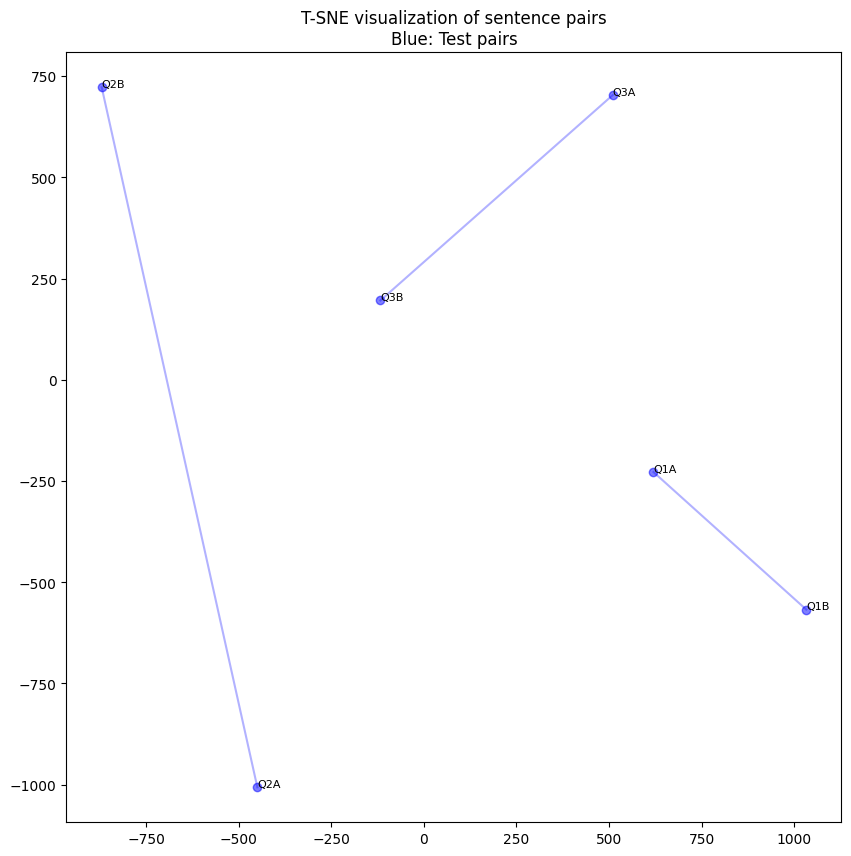

In [35]:
# Visualize the test pairs
visualize_embeddings(pairs=test_pairs)

C:\Users\Han Saputra\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


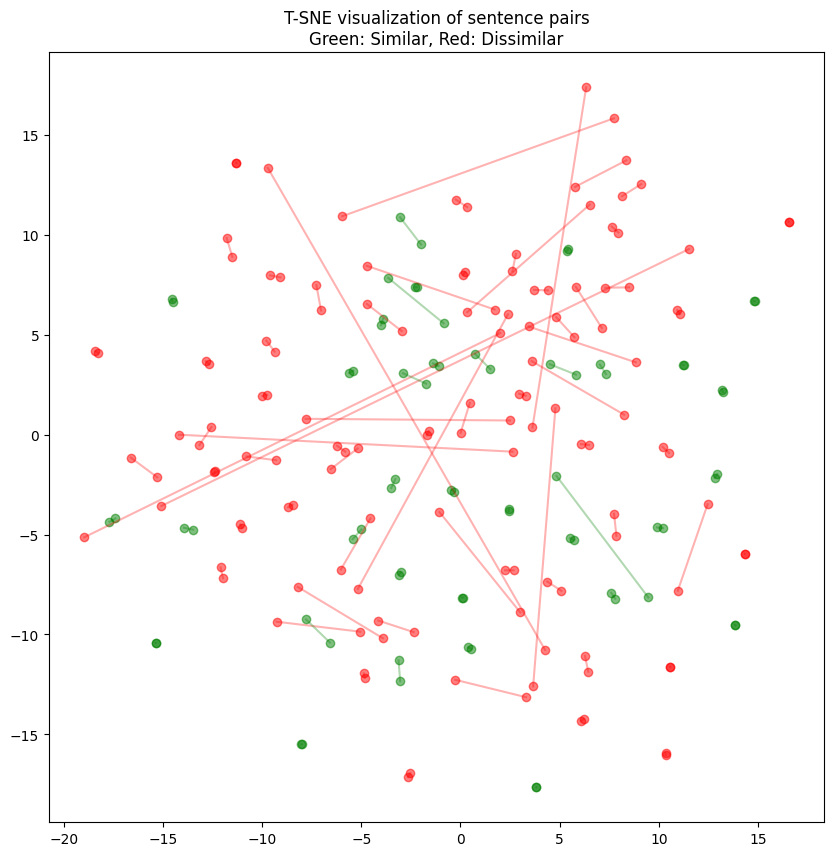

In [ ]:
# visualize training samples
# Plots pairs of points connected by lines:
# - Green lines/points for similar pairs
# - Red lines/points for dissimilar pairs
visualize_embeddings(n_samples=100)

As we can see based on this 2D visualization, the dissimilar pairs are relatively pushed apart and the similar pairs are brought closer together.

Disclaimer: 2D visualization is not the best way to visualize embeddings, but it gives a rough idea of how the embeddings are being learned.